In [3]:
%matplotlib inline
# ruff: noqa: I001
import itertools
import tempfile
from pathlib import Path

import numpy as np
from shapely.geometry import MultiLineString, MultiPolygon, Polygon, box, shape

from sentinelhub import (
    CRS,
    BBox,
    SHConfig,
    BBoxSplitter,
    CustomGridSplitter,
    DataCollection,
    MimeType,
    MosaickingOrder,
    OsmSplitter,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    TileSplitter,
    UtmGridSplitter,
    UtmZoneSplitter,
    read_data
)
import os

from sentinelhub import (
    SHConfig,
    SentinelHubCatalog,
    Geometry,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray  # noqa: F401 # Its necesary for xarray.open_mfdataset() with engine `rasterio`
import xarray as xr  # It may need Dask library https://docs.dask.org/en/stable/install.html
from matplotlib.patches import Polygon as PltPolygon
from mpl_toolkits.basemap import Basemap  # Available here: https://github.com/matplotlib/basemap

/home/matheus/app/copernicus-sentinelhub/venv-copernicus/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# ruff: noqa: C901

INPUT_FILE = "./data/Hawaii.json"

geo_json = read_data(INPUT_FILE)
hawaii_area = shape(geo_json["features"][0]["geometry"])

type(hawaii_area)

shapely.geometry.multipolygon.MultiPolygon

In [7]:
# ruff: noqa: C901

INPUT_FILE = "./data/um_reservatorio_so2copy.json"

ge_json = read_data(INPUT_FILE)
reservatorio = shape(ge_json["features"][0]["geometry"])

type(reservatorio)

shapely.geometry.multipolygon.MultiPolygon

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NotImplementedError: Sub-geometries may have coordinate sequences, but multi-part geometries do not

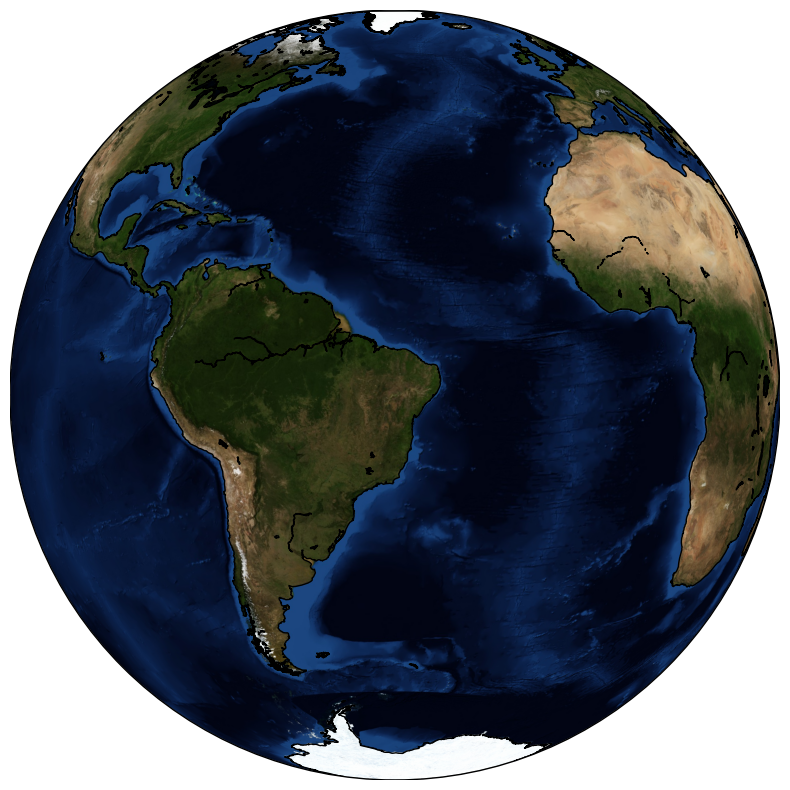

In [9]:
def show_area(area_shape):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    minx, miny, maxx, maxy = area_shape.bounds
    lng, lat = (minx + maxx) / 2, (miny + maxy) / 2

    m = Basemap(projection="ortho", lat_0=lat, lon_0=lng, resolution="l")
    m.drawcoastlines()
    m.bluemarble()

    if isinstance(area_shape, Polygon):
        polygon_iter = [area_shape]
    elif isinstance(area_shape, MultiPolygon):
        polygon_iter = area_shape.geoms
    else:
        raise ValueError(f"Geometry of type {type(area_shape)} is not supported")

    for polygon in polygon_iter:
        x, y = np.array(polygon.boundary.coords)[0]
        m_poly = []
        for x, y in np.array(polygon.boundary.coords):
            m_poly.append(m(x, y))
        ax.add_patch(PltPolygon(np.array(m_poly), closed=True, facecolor="red", edgecolor="red"))

    plt.tight_layout()
    plt.show()


show_area(reservatorio)

In [ ]:
bbox_splitter = BBoxSplitter(
    [test_bbox], CRS.WGS84, (5, 4)
)  # bounding box will be split into grid of 5x4 bounding boxes

print("Area bounding box: {}\n".format(bbox_splitter.get_area_bbox().__repr__()))

bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

print(
    "Each bounding box also has some info how it was created.\nExample:\nbbox: {}\ninfo: {}\n".format(
        bbox_list[0].__repr__(), info_list[0]
    )
)

In [ ]:
geometry_list = bbox_splitter.get_geometry_list()

geometry_list[0]


In [ ]:
def show_splitter(splitter, alpha=0.2, area_buffer=0.2, show_legend=False):
    area_bbox = splitter.get_area_bbox()
    minx, miny, maxx, maxy = area_bbox
    lng, lat = area_bbox.middle
    w, h = maxx - minx, maxy - miny
    minx = minx - area_buffer * w
    miny = miny - area_buffer * h
    maxx = maxx + area_buffer * w
    maxy = maxy + area_buffer * h

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    base_map = Basemap(
        projection="mill",
        lat_0=lat,
        lon_0=lng,
        llcrnrlon=minx,
        llcrnrlat=miny,
        urcrnrlon=maxx,
        urcrnrlat=maxy,
        resolution="l",
        epsg=4326,
    )
    base_map.drawcoastlines(color=(0, 0, 0, 0))

    area_shape = splitter.get_area_shape()

    if isinstance(area_shape, Polygon):
        polygon_iter = [area_shape]
    elif isinstance(area_shape, MultiPolygon):
        polygon_iter = area_shape.geoms
    else:
        raise ValueError(f"Geometry of type {type(area_shape)} is not supported")

    for polygon in polygon_iter:
        if isinstance(polygon.boundary, MultiLineString):
            for linestring in polygon.boundary:
                ax.add_patch(PltPolygon(np.array(linestring), closed=True, facecolor=(0, 0, 0, 0), edgecolor="red"))
        else:
            ax.add_patch(
                PltPolygon(np.array(polygon.boundary.coords), closed=True, facecolor=(0, 0, 0, 0), edgecolor="red")
            )

    bbox_list = splitter.get_bbox_list()
    info_list = splitter.get_info_list()

    cm = plt.get_cmap("jet", len(bbox_list))
    legend_shapes = []
    for i, bbox in enumerate(bbox_list):
        wgs84_bbox = bbox.transform(CRS.WGS84).get_polygon()

        tile_color = tuple(list(cm(i))[:3] + [alpha])
        ax.add_patch(PltPolygon(np.array(wgs84_bbox), closed=True, facecolor=tile_color, edgecolor="green"))

        if show_legend:
            legend_shapes.append(plt.Rectangle((0, 0), 1, 1, fc=cm(i)))

    if show_legend:
        legend_names = []
        for info in info_list:
            legend_name = "{},{}".format(info["index_x"], info["index_y"])

            for prop in ["grid_index", "tile"]:
                if prop in info:
                    legend_name = "{},{}".format(info[prop], legend_name)

            legend_names.append(legend_name)

        plt.legend(legend_shapes, legend_names)
    plt.tight_layout()
    plt.show()

In [ ]:
show_splitter(bbox_splitter, show_legend=True)

In [ ]:
bbox_splitter_reduced = BBoxSplitter([test_bbox], CRS.WGS84, (5,4), reduce_bbox_sizes=True)

show_splitter(bbox_splitter_reduced, show_legend=True)

In [ ]:
osm_splitter = OsmSplitter([test_bbox], CRS.WGS84, zoom_level=10)

print(repr(osm_splitter.get_bbox_list()[0]))
print(osm_splitter.get_info_list()[0])

In [ ]:
show_splitter(osm_splitter, show_legend=True)

In [ ]:
tile_splitter = TileSplitter(
    [eletro_nuclear], 
    CRS.WGS84,
    ("2023-10-01", "2023-11-01"),
    data_collection=DataCollection.SENTINEL2_L1C.define_from("s2l1c", service_url=config.sh_base_url),
    config=config,
)

tile_bbox_list = tile_splitter.get_bbox_list()

print(len(tile_bbox_list))
print(tile_bbox_list[0].__repr__())
print(tile_splitter.get_info_list()[0])

In [ ]:
tile_splitter.get_bbox_list(crs=CRS.WGS84)[0]

In [ ]:
show_splitter(tile_splitter)

In [ ]:
finer_tile_splitter = TileSplitter(
    [eletro_nuclear],
    CRS.WGS84,
    ("2022-10-01", "2023-03-01"),
    tile_split_shape=(7, 3),
    data_collection=DataCollection.SENTINEL2_L1C,
    config=config,
)

show_splitter(finer_tile_splitter, show_legend=False)

In [ ]:
bbox_grid = [BBox((x, y, x + 1, y + 1), CRS.WGS84) for x, y in itertools.product(range(-49, -47), range(18,23))]

bbox_grid

In [ ]:
custom_grid_splitter = CustomGridSplitter([eletro_nuclear], CRS.WGS84, bbox_grid)

show_splitter(custom_grid_splitter)

In [ ]:

utm_zone_splitter = UtmZoneSplitter([eletro_nuclear], CRS.WGS84, (50000, 50000))

show_splitter(utm_zone_splitter, show_legend=True)

In [ ]:
utm_zone_splitter.get_bbox_list()

In [ ]:
utm_grid_splitter = UtmGridSplitter([eletro_nuclear], CRS.WGS84, (50000, 50000))

show_splitter(utm_grid_splitter, show_legend=True)

In [ ]:
kauai = eletro_nuclear.geoms[0]
kauai_split = BBoxSplitter([kauai], CRS.WGS84, (2, 2))
show_splitter(kauai_split, show_legend=True)

In [ ]:
ndvi_eval = """
//VERSION=3

function evaluatePixel(samples) {
    let val = index(samples.B08, samples.B04);
    return [val];
}

function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 1
    }
  }
}
"""

In [ ]:
def get_subarea(bbox):
    return SentinelHubRequest(
        evalscript=ndvi_eval,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=("2020-10-01", "2022-10-13"),
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=(1250, 1250),
        data_folder=tempfile.gettempdir(),
        config=config,
    )

In [ ]:
# create a list of requests
bbox_list = kauai_split.get_bbox_list()
sh_requests = [get_subarea(bbox) for bbox in bbox_list]
dl_requests = [request.download_list[0] for request in sh_requests]

# download data with multiple threads
downloaded_data = SentinelHubDownloadClient(config=config).download(dl_requests, max_threads=5)

In [ ]:
data_folder = sh_requests[0].data_folder
tiffs = [Path(data_folder) / req.get_filename_list()[0] for req in sh_requests]

In [ ]:
def plot_xr_and_bboxes(data_array, geo_vector=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    data_array.plot(ax=ax)
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")
    ax.set_aspect(1)
    if geo_vector is not None:
        geo_vector.plot(ax=ax, edgecolor="red", facecolor="none")
    plt.show()

In [ ]:
composed_tiff = xr.open_mfdataset(tiffs, engine="rasterio")
composed_map = composed_tiff.band_data.isel(band=0)

plot_xr_and_bboxes(composed_map)